# Unsupervised learning models for clustering economic series

- KMeans, agglomerative, spectral clustering, nearest neighbors, PCA
- sklearn, FRED-MD

Terence Lim

In [11]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import re
import time
from datetime import datetime
from finds.alfred import fred_md, Alfred
from settings import settings
imgdir = os.path.join(settings['images'], 'ts')

# Load and pre-process time series from FRED
alf = Alfred(api_key=settings['fred']['api_key'])
usrec = alf('USREC', freq='m')   # to indicate recession periods in the plots
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = (usrec != usrec.shift()).cumsum()[usrec.gt(0)].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]

# Retrieve FRED-MD series
mdf, mt = fred_md(202104)        # from vintage April 2020
beg = 19600301
end = 20191231 # 20191231

# Apply tcode transformations, DatetimeIndex, and sample beg:end
df = mdf
t = mt['transform']
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=t[col], freq='m'))
df = pd.concat(transformed, axis=1).iloc[2:]
data = df[(df.index >= beg) & (df.index <= end)].dropna(axis=1)
data.index = pd.DatetimeIndex(data.index.astype(str), freq='infer')
cols = list(data.columns)
data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
1960-03-31,0.001910,0.000918,0.014072,-0.028021,-0.001102,-0.009017,-0.003429,-0.001146,0.001154,-0.019963,...,0.001786,-0.001025,-0.000020,0.030131,-0.004684,0.0,0.002087,0.003472,0.000951,0.003490
1960-04-30,0.003426,0.003621,0.015382,0.009836,0.025903,-0.007961,0.002287,0.001146,0.006880,-0.001189,...,0.004439,0.001531,-0.008949,-0.068074,0.000000,0.0,-0.000701,0.008678,0.005452,0.024136
1960-05-31,0.002403,0.002448,-0.020417,-0.031588,-0.015047,-0.001143,0.005691,0.006866,0.005698,0.009454,...,-0.006723,0.000504,0.008949,0.041620,0.000000,-6.7,0.000688,-0.004827,-0.002067,0.003798
1960-06-30,0.000789,-0.000249,-0.000219,0.008606,-0.001364,-0.012650,-0.011414,-0.011467,-0.006841,-0.010645,...,0.000222,-0.000768,-0.004474,-0.011429,0.000000,0.0,0.001027,0.005126,0.007420,-0.009981
1960-07-31,0.001832,0.001905,0.002028,-0.006865,-0.010099,-0.003479,-0.005760,-0.005783,-0.009197,-0.038793,...,0.001828,0.000672,0.004454,0.007547,0.000000,0.0,0.001358,-0.010926,-0.003291,0.032176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.003939,0.004500,0.001996,0.006078,0.004583,0.007026,0.002296,0.001162,-0.001151,-0.002982,...,-0.004421,-0.000861,0.002418,0.006312,-0.000455,-8.6,-0.000065,-0.000454,-0.001618,0.004466
2019-09-30,0.001060,0.001053,0.001058,-0.000568,-0.006205,-0.003482,-0.005801,-0.007862,-0.006961,-0.028895,...,-0.000517,-0.000510,-0.001215,-0.003160,-0.000902,3.4,0.000708,-0.004019,-0.001818,0.005219
2019-10-31,0.000689,0.000732,0.001849,-0.003912,0.004826,-0.004078,-0.002713,-0.002710,-0.000629,-0.028124,...,0.005605,0.000749,0.000397,-0.000352,0.001345,2.3,0.002559,0.001965,0.000655,-0.014785
2019-11-30,0.004293,0.005235,0.000899,0.005130,0.003240,0.009237,0.013744,0.017824,0.019420,0.059730,...,-0.001718,-0.000804,-0.001206,0.000346,0.001336,1.3,-0.001818,-0.002352,-0.001207,0.004470


## helpers to estimate explained variance

In [2]:
from collections import namedtuple
def lm(x, y, add_constant=True, flatten=True):
    """Calculate linear multiple regression model results as namedtuple"""
    def f(a):
        """helper to optionally flatten 1D array"""
        if not flatten or not isinstance(a, np.ndarray):
            return a
        if len(a.shape) == 1 or a.shape[1] == 1:
            return float(a) if a.shape[0] == 1 else a.flatten()
        return a.flatten() if a.shape[0] == 1 else a
    X = np.array(x)
    Y = np.array(y)
    if len(X.shape) == 1 or X.shape[0]==1:
        X = X.reshape((-1,1))
    if len(Y.shape) == 1 or Y.shape[0]==1:
        Y = Y.reshape((-1,1))
    if add_constant:
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    b = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    out = {'coefficients': f(b)}
    out['fitted'] = f(X @ b)
    out['residuals'] = f(Y) - out['fitted']
    out['rsq'] = f(np.var(out['fitted'], axis=0)) / f(np.var(Y, axis=0))
    out['rvalue'] = f(np.sqrt(out['rsq']))
    out['stderr'] = f(np.std(out['residuals'], axis=0))
    return namedtuple('LinearModel', out.keys())(**out)

def cluster_rsq(y, centers, labels=None):
    """Calculate within-cluster average rsquared of y to its labelled center"""
    if labels is None:
        return np.mean(lm(y=y.T, x=centers.T).rsq)
    labels = labels.flatten()
    return np.sum([np.sum(lm(y=y.T[:, labels == p], x=centers.T[:,p]).rsq)
                   for p in np.unique(labels)]) / len(labels)

from sklearn.neighbors import NearestNeighbors
def print_nearest(centers, neighbors, labels, n_neighbors=3):
    """Display each center's nearest labeled neighbors, and variance explained"""
    
    c = centers / centers.std(ddof=0, axis=1)[:, None]   # standardize centers
    l = labels.flatten()
    neigh = NearestNeighbors(n_neighbors, radius=None, algorithm='brute')
    for k in range(c.shape[0]):
        # find nearest labelled neighbors of center[k]
        sz = np.sum(l == k)
        r2 = cluster_rsq(neighbors[l==k], c[[k]])
        print(f"Cluster:{k:2d}  size:{sz}  R2:{r2:.3f}")
        if n_neighbors:
            neigh.fit(neighbors[l==k])
            dist, nearest = neigh.kneighbors(c[[k]], min(sz, n_neighbors),
                                             return_distance=True)
            for arg in nearest[0]:
                col = np.array(cols)[l==k][arg]
                print(f"{col:16s} {alf.header(col)}")
            print()
    print()


# Clustering of economic variables
- input y shall have shape (n_samples=variables, n_features=monthly values)
- StandardScaler standardizes by column: note we want to normalize each variable
  hence first apply StandardScaler to (monthly values, variables), then tranpose


In [4]:
from sklearn.preprocessing import StandardScaler
y = StandardScaler().fit_transform(np.asarray(data)).T
within_rsq = dict()    # collect average within-cluster rsquareds
total_rsq = dict()     # collect total rsquareds
max_clusters = 8


# KMeans clustering with MiniBatch

In [5]:
from sklearn.cluster import MiniBatchKMeans, KMeans

modelname = 'KMeans'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
#    km = MiniBatchKMeans(n_clusters=n_clusters, batch_size=6, max_iter=100)
    km = KMeans(n_clusters=n_clusters, max_iter=100)    
    best = 0.0
    for trial in range(10):  # kmeans may get stuck in local optimums
        km.fit(y)
        r = cluster_rsq(y, km.cluster_centers_, km.labels_)
        if r > best:
            best = r
            kmeans = deepcopy(km)
            rsq[n_clusters] = best
            ttl[n_clusters] = lm(y=y.T, x=km.cluster_centers_.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-clusters Rsquare:",
      f"{cluster_rsq(y, kmeans.cluster_centers_, kmeans.labels_):.3f}")
print(f"Total Rsquare: {lm(y=y.T, x=kmeans.cluster_centers_.T).rsq.mean():.3f}")
print_nearest(kmeans.cluster_centers_, neighbors=y, labels=kmeans.labels_)


Model [KMeans] Average Within-clusters Rsquare: 0.409
Total Rsquare: 0.453
Cluster: 0  size:9  R2:0.712
T5YFFM           5-Year Treasury Constant Maturity Minus Federal Funds Rate
T10YFFM          10-Year Treasury Constant Maturity Minus Federal Funds Rate
TB6SMFFM         6-Month Treasury Bill Minus Federal Funds Rate

Cluster: 1  size:19  R2:0.424
PAYEMS           All Employees, Total Nonfarm
USGOOD           All Employees, Goods-Producing
MANEMP           All Employees, Manufacturing

Cluster: 2  size:13  R2:0.628
CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
DNDGRG3M086SBEA  Personal consumption expenditures: Nondurable goods (chain-type price index)
CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Average

Cluster: 3  size:39  R2:0.049
UEMP15OV         Number Unemployed for 15 Weeks & Over
UNRATE           Unemployment Rate
M2SL             M2 Money Stock

Cluster: 4  size:11  R2:0.

# PCA components as cluster centers


In [6]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

modelname = 'PCA'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    pca = PCA(n_components=n_clusters).fit(y)
    
    ## assign label as nearest center
    centers = pca.components_ / pca.components_.std(ddof=0, axis=1)[:, None]
    neigh = NearestNeighbors(1, algorithm='brute', radius=None).fit(centers)
    dists, labels = neigh.kneighbors(y, return_distance=True)
    
    rsq[n_clusters] = cluster_rsq(y, centers, labels)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, labels):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=labels)


Model [PCA] Average Within-cluster Rsquare: 0.131
Total Rsquare: 0.467
Cluster: 0  size:17  R2:0.090
UNRATE           Unemployment Rate
UEMP15OV         Number Unemployed for 15 Weeks & Over
CLAIMS           Initial Claims

Cluster: 1  size:28  R2:0.165
AAAFFM           Moody's Seasoned Aaa Corporate Bond Minus Federal Funds Rate
T10YFFM          10-Year Treasury Constant Maturity Minus Federal Funds Rate
BAAFFM           Moody's Seasoned Baa Corporate Bond Minus Federal Funds Rate

Cluster: 2  size:5  R2:0.102
ISRATIO          Total Business: Inventories to Sales Ratio
S&P div yield    S&P's Composite Common Stock: Dividend Yield
EXCAUS           Canada / U.S. Foreign Exchange Rate

Cluster: 3  size:21  R2:0.197
GS1              1-Year Treasury Constant Maturity Rate
TB6MS            6-Month Treasury Bill: Secondary Market Rate
GS5              5-Year Treasury Constant Maturity Rate

Cluster: 4  size:10  R2:0.165
PERMIT           New Privately-Owned Housing Units Authorized in Permit-

# Spectral clustering

In [7]:
from sklearn.cluster import SpectralClustering

modelname = 'Spectral'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    spectral = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack',
                                  affinity="nearest_neighbors").fit(y)
    
    # assign centers as medians of each feature (monthly values)
    centers = np.hstack([StandardScaler()\
                         .fit_transform(np.median(y[spectral.labels_ == c],
                                                  axis=0).reshape(-1,1))
                         for c in range(max(spectral.labels_+1))]).T
    
    rsq[n_clusters] = cluster_rsq(y, centers, spectral.labels_)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, spectral.labels_):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=spectral.labels_)


Model [Spectral] Average Within-cluster Rsquare: 0.388
Total Rsquare: 0.421
Cluster: 0  size:21  R2:0.361
CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
DNDGRG3M086SBEA  Personal consumption expenditures: Nondurable goods (chain-type price index)
CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Average

Cluster: 1  size:9  R2:0.211
TOTRESNS         Total Reserves of Depository Institutions
BOGMBASE         Monetary Base; Total
M2SL             M2 Money Stock

Cluster: 2  size:20  R2:0.379
PAYEMS           All Employees, Total Nonfarm
USGOOD           All Employees, Goods-Producing
MANEMP           All Employees, Manufacturing

Cluster: 3  size:10  R2:0.232
UEMP15OV         Number Unemployed for 15 Weeks & Over
UNRATE           Unemployment Rate
UEMP27OV         Number Unemployed for 27 Weeks & Over

Cluster: 4  size:10  R2:0.767
HOUST            New Privately-Owned Housing Units Started: 

# Ward Hierarchical Clustering

In [8]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
connectivity = kneighbors_graph(y, n_neighbors=len(y)//2, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

from sklearn.cluster import SpectralClustering

modelname = 'Ward'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                   connectivity=connectivity).fit(y)

    # assign centers as means of each feature (monthly values)
    centers = np.hstack([StandardScaler()\
                         .fit_transform(np.mean(y[ward.labels_ == c],
                                                axis=0).reshape(-1,1))
                     for c in range(max(ward.labels_+1))]).T

    rsq[n_clusters] = cluster_rsq(y, centers, ward.labels_)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, ward.labels_):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=ward.labels_)


Model [Ward] Average Within-cluster Rsquare: 0.404
Total Rsquare: 0.451
Cluster: 0  size:44  R2:0.041
UEMP15OV         Number Unemployed for 15 Weeks & Over
M2SL             M2 Money Stock
UNRATE           Unemployment Rate

Cluster: 1  size:26  R2:0.336
PAYEMS           All Employees, Total Nonfarm
USGOOD           All Employees, Goods-Producing
MANEMP           All Employees, Manufacturing

Cluster: 2  size:13  R2:0.628
CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
DNDGRG3M086SBEA  Personal consumption expenditures: Nondurable goods (chain-type price index)
CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Average

Cluster: 3  size:9  R2:0.725
GS1              1-Year Treasury Constant Maturity Rate
TB6MS            6-Month Treasury Bill: Secondary Market Rate
GS5              5-Year Treasury Constant Maturity Rate

Cluster: 4  size:10  R2:0.773
HOUST            New Privately-Owned Housi

# AverageLinkage Hierarchical Clustering
- with cityblock distance

In [9]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
connectivity = kneighbors_graph(y, n_neighbors=len(y)//2, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

modelname = 'AvgLink'
rsq, ttl = dict(), dict()
for n_clusters in range(2, max_clusters+1):
    avglink = AgglomerativeClustering(linkage="average", affinity="cityblock",
                                      n_clusters=n_clusters,
                                      connectivity=connectivity).fit(y)

    # assign centers as means of each feature (monthly values)
    centers = np.hstack([StandardScaler()\
                         .fit_transform(np.mean(y[avglink.labels_ == c],
                                                axis=0).reshape(-1,1))
                     for c in range(max(avglink.labels_+1))]).T

    rsq[n_clusters] = cluster_rsq(y, centers, avglink.labels_)
    ttl[n_clusters] = lm(y=y.T, x=centers.T).rsq.mean()
within_rsq[modelname] = rsq
total_rsq[modelname] = ttl

# show clusters
print(f"Model [{modelname}] Average Within-cluster Rsquare:",
      f"{cluster_rsq(y, centers, avglink.labels_):.03f}")
print(f"Total Rsquare: {lm(y=y.T, x=centers.T).rsq.mean():.3f}")
print_nearest(centers, neighbors=y, labels=avglink.labels_)


Model [AvgLink] Average Within-cluster Rsquare: 0.211
Total Rsquare: 0.263
Cluster: 0  size:3  R2:0.485
IPNCONGD         Industrial Production: Non-Durable Consumer Goods
IPB51222S        Industrial Production: Non-Durable Consumer Energy Products: Residential Utilities
IPFUELS          Industrial Production: Non-Durable Consumer Energy Products: Fuels

Cluster: 1  size:102  R2:0.145
PAYEMS           All Employees, Total Nonfarm
IPMANSICS        Industrial Production: Manufacturing (SIC)
USGOOD           All Employees, Goods-Producing

Cluster: 2  size:2  R2:0.574
BUSLOANS         Commercial and Industrial Loans, All Commercial Banks
INVEST           Securities in Bank Credit, All Commercial Banks

Cluster: 3  size:7  R2:0.375
UEMP15OV         Number Unemployed for 15 Weeks & Over
UNRATE           Unemployment Rate
UEMP27OV         Number Unemployed for 27 Weeks & Over

Cluster: 4  size:2  R2:0.663
ISRATIO          Total Business: Inventories to Sales Ratio
CLAIMS           Initial Cla

## Plot within-cluster and total variance explained
- PCA seeks to maximize total rsquare, while KMeans (with Euclidean distance) seeks to maximize within-cluster rsquare
- Agglomerative or Hierarchical methods approximate these, although for the Average Linking method, we used Manhattan rather than Euclidean distances, hence appears poorer through ``variance explained'' (or Euclidean) metrics.


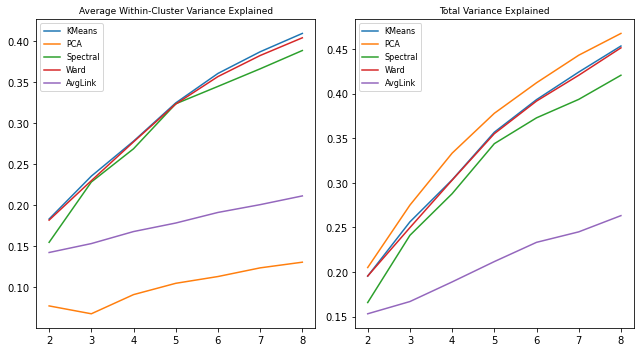

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,5), num=1, clear=True)
for v, title, ax in zip([DataFrame(within_rsq), DataFrame(total_rsq)],
                        ['Average Within-Cluster Variance Explained',
                         'Total Variance Explained'], axes.ravel()):
    v.plot(ax=ax, style='-', rot=0)
    ax.set_title(title, {'fontsize':9})
    ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'clusters.jpg'))
plt.show()